In [0]:
# The data are downloaded from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/home
# Upload the data to the google drive to training and tuning 
# Link the CWD to the data directory in the google drive 

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
path=os.getcwd()
# check to see if the CWD is in the correct path 
path0=path+'/drive/My Drive/Colab Notebooks/train/NORMAL/'
print (path0)

/content/drive/My Drive/Colab Notebooks/train/NORMAL/


In [0]:
# import ImageDataGenerator, use this to generate and view several examples of the Augmented pictures
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [0]:
# CNN architecture 
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
K.set_image_dim_ordering('th')

keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(32, (3, 3),activation='relu',input_shape=(3, 150, 150)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))
model.add(Dropout(0.25))



model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


In [0]:
# brief view of model summary 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 148, 148)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 148, 148)      592       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 148, 148)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 74, 74)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 72, 72)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 72, 72)        288       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 72, 72)        0         
__________

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file=path+'/drive/My Drive/Colab Notebooks/chest x-ray/'+'model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
batch_size = 128
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        path+'/drive/My Drive/Colab Notebooks/chest x-ray/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary', # since we only have two classes, we need binary labels 
        shuffle=False)  

# for validation data
validation_generator = test_datagen.flow_from_directory(
        path+'/drive/My Drive/Colab Notebooks/chest x-ray/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

# for evaluation data 
evaluation_generator = test_datagen.flow_from_directory(
        path+'/drive/My Drive/Colab Notebooks/chest x-ray/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
# call back plot function to plot accuracy of the training set 
import keras
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

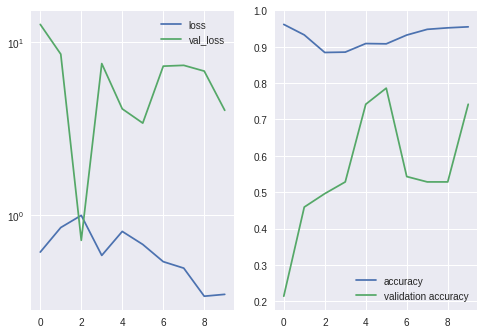

In [0]:
model.fit_generator(
        train_generator,
        steps_per_epoch=5216 // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=624 // batch_size,
        callbacks=[plot]
        )

In [0]:
!pip install livelossplot
from livelossplot.keras import PlotLossesCallback
plot_losses = PlotLossesCallback()

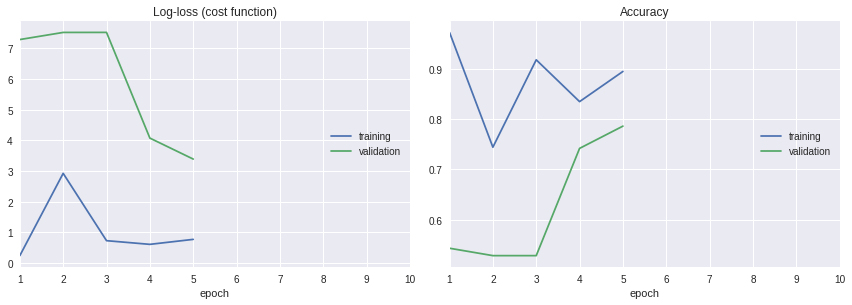

Log-loss (cost function):
training   (min:    0.241, max:    2.923, cur:    0.771)
validation (min:    3.389, max:    7.519, cur:    3.389)

Accuracy:
training   (min:    0.744, max:    0.973, cur:    0.895)
validation (min:    0.528, max:    0.786, cur:    0.786)
Epoch 6/10
 3/40 [=>............................] - ETA: 1:37 - loss: 0.0014 - acc: 1.0000

In [0]:
model.fit_generator(
        train_generator,
        steps_per_epoch=5216 // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=624 // batch_size,
        callbacks=[plot_losses]
        )

In [0]:
# save 
model.save_weights(path+'/drive/My Drive/Colab Notebooks/chest x-ray/2nd try/first try.h5')

In [0]:
model.load_weights(path+'/drive/My Drive/Colab Notebooks/chest x-ray/1st try/first try.h5')

In [0]:
print(model.evaluate_generator(evaluation_generator,steps=10))
print (model.metrics_names)

[7.217132091522217, 0.5]
['loss', 'acc']


In [0]:
print(model.evaluate_generator(validation_generator,steps=10))
print (model.metrics_names)

[5.8261695925703885, 0.625]
['loss', 'acc']
